* json how to: https://realpython.com/python-requests/
* USA source: https://covidtracking.com/us-daily/
* world source: https://www.trackcorona.live
* state pop source: https://www.census.gov/data/datasets/time-series/demo/popest/2010s-state-total.html#par_textimage_1873399417
* state abbreviation source: https://www.50states.com/abbreviations.htm

# State

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests


Bad key "text.kerning_factor" on line 4 in
/opt/tljh/user/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
state_response = requests.get('https://covidtracking.com/api/states')

if state_response.status_code == 200:
    print('Success!')
else:
    print('An error has occurred')
    exit()


Success!


In [3]:
# Convert json to df
df_state = pd.json_normalize(state_response.json())

In [4]:
# Import states, abbreviations, state population
abbrevs = pd.read_csv('abbrevs.csv')
statepop = pd.read_csv('statepop.csv').iloc[5:].loc[:,('NAME','POPESTIMATE2019')].reset_index(drop = True)
state_pop = abbrevs.merge(statepop, left_on='State', right_on='NAME').loc[:,('NAME','Abbreviation','POPESTIMATE2019')]
state_pop.columns = ['state','abbrev','Pop2019']

In [320]:
class state_tracker:
    '''
    Returns covid stats, sorts by preference, and plots results
    '''
    def __init__(self, df, state_pop=state_pop, states_list=['MA', 'TX', 'OH', 'VT']):
        '''
        Selects appropriate columns and filters by state. Calculates percent deaths and percent hospitalized.
        
        % Deaths = Deaths/Positive
        % Hospitalized = Hospitalized/Positive
        '''
        # Select appropriate columns
        self.df = df[['state','positive','negative','hospitalized','death','lastUpdateEt']]
        # Rename columns
        self.df.columns = ['State', 'Positive', 'Negative', 'Hospitalized', 'Deaths', 'Last Updated']
        # Replace NaN with 0
        self.df = self.df.fillna(0)
        
        self.state_pop = state_pop
        self.merged = self.df.merge(self.state_pop, left_on='State', right_on='abbrev')
        self.merged = self.merged.drop(['state','abbrev'], 1)
        
        df_select = self.merged
        # Percent death calculation
        df_select['% Deaths'] = round((df_select['Deaths']/df_select['Positive']) *100,2)
        df_select['% Hospitalized'] = round((df_select['Hospitalized']/df_select['Positive']) *100,2)
        df_select['% Pop Positive'] = round((df_select['Positive']/df_select['Pop2019']) *100,2)
        
        # Select the states
        self.jnd = '|'.join(states_list)
        df_select = self.merged[self.merged['State'].str.contains(self.jnd)]
               
        self.df_select = pd.DataFrame(df_select)
    def all_df(self):
        '''
        Returns all states, select columns only.
        '''
        return self.merged
    
    def plotter(self, sort_by="% Hospitalized"):
        '''
        Plots the formatted df by the sort_by variable.
        '''
        df = self.df_select.sort_values(sort_by, ascending=False)
        sns.barplot(x = df.State, y = df[sort_by])
        if sort_by=="% Pop Positive":
            plt.title(f"{sort_by} per State")
        else:
            plt.title(f"Number of {sort_by} results per State")
        
        return plt.show()
    
    def table(self, sort_by="% Hospitalized"):
        '''
        Returns the formatted df, but in a readable and prettified table
        
        Adds commas at 1000 values
        Adds % to the percent tables
        All values are in string
        '''
        df_select = self.df_select
        df_select = df_select.sort_values(sort_by, ascending = False)

        # Prettify output
        # Format percentages
        df_select['% Deaths'] = df_select['% Deaths'].apply(str) + "%"
        df_select['% Hospitalized'] = df_select['% Hospitalized'].apply(str) + "%"
        df_select['% Pop Positive'] = df_select['% Pop Positive'].apply(str) + "%"

        # Round floats to just integers, use commas to separate
        columns = ['Positive', 'Negative', 'Hospitalized', 'Deaths', 'Pop2019']

        for col in columns:
            df_select[col] = pd.to_numeric(df_select[col]).apply(round)
            df_select[col] = df_select[col].apply(lambda x: "{:,}".format(x))
        self.table = df_select
        return(self.table)


In [321]:
yan = ['MA', 'TX', 'OH', 'VT', 'NY', 'NJ', 'CA']
chat = ['MA', 'TX', 'OH', 'VT']

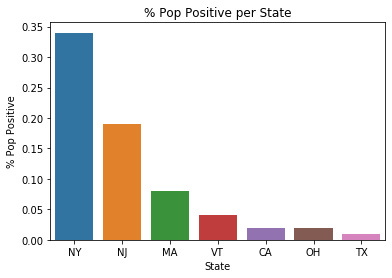

In [322]:
covid = state_tracker(df_state, states_list=yan)
covid.plotter(sort_by="% Pop Positive")

In [323]:
covid.table(sort_by = "% Pop Positive")

,State,Positive,Negative,Hospitalized,Deaths,Last Updated,Pop2019,% Deaths,% Hospitalized,% Pop Positive
33,NY,"66,497","119,971","13,721","1,218",3/29 09:16,"19,453,561",1.83%,20.63%,0.34%
30,NJ,"16,636","25,224",0,198,3/30 14:00,"8,882,190",1.19%,0.0%,0.19%
18,MA,"5,752","37,041",453,56,3/30 16:15,"6,892,503",0.97%,7.88%,0.08%
45,VT,256,"3,674",18,12,3/30 13:00,"623,989",4.69%,7.03%,0.04%
4,CA,"7,398","21,488","1,432",146,3/30 00:00,"39,512,223",1.97%,19.36%,0.02%
34,OH,"1,933","25,342",475,39,3/30 14:00,"11,689,100",2.02%,24.57%,0.02%
42,TX,"2,877","33,003",0,34,3/30 12:45,"28,995,881",1.18%,0.0%,0.01%


In [324]:
all_df = covid.all_df()
all_pos = all_df.sum()["Positive"]
all_dead = all_df.sum()["Deaths"]
all_hosp = all_df.sum()["Hospitalized"]

print("Totals in the USA to date:")
print(f'     Infected: {"{:,}".format(round(all_pos))}')
print(f'     Hospitalized: {"{:,}".format(round(all_hosp))}') 
print(f'     Deaths: {"{:,}".format(round(all_dead))}')

Totals in the USA to date:
     Infected: 161,640
     Hospitalized: 22,471
     Deaths: 2,965


# World

In [12]:
import time

In [11]:
world_response = requests.get('https://www.trackcorona.live/api/countries/')

if world_response.status_code == 200:
    print('Success!')
else:
    print('An error has occurred')
    exit()

Success!


In [12]:
# Convert json to df
df_world = pd.json_normalize(world_response.json()['data'])

In [13]:
country_list = ['United States', 'Hungary', 'Jordan', 'Brazil', 'Cambodia', 'Germany','Mexico', 'China']

In [309]:
def world_tracker(df, country_list=country_list):
    df = df.loc[:, ['location', 'confirmed','dead','recovered','updated']]
    df.columns = ["Location","Confirmed", "Dead", "Recovered", "Updated"]
    
    jnd = '|'.join(country_list)
    df = df[df['Location'].str.contains(jnd)]
    
    df = df.sort_values("Confirmed", ascending=False)
    return df

In [310]:
world_tracker(df_world)

,Location,Confirmed,Dead,Recovered,Updated
15,United States,164496,3173,5945,2020-03-31 14:00:09.971177+00:00
131,China,81518,3305,76052,2020-03-31 14:00:10.105434+00:00
114,Germany,67987,707,7635,2020-03-31 14:00:10.121562+00:00
104,Brazil,4661,165,127,2020-03-31 14:00:10.513702+00:00
166,Mexico,1094,28,35,2020-03-31 14:00:11.281606+00:00
46,Hungary,492,16,37,2020-03-31 14:00:11.634069+00:00
16,Jordan,268,5,26,2020-03-31 14:00:11.735062+00:00
30,Cambodia,109,0,23,2020-03-31 14:00:11.904729+00:00


# Counties and Cities

## Import from Sources

In [119]:
city_response = requests.get('https://www.trackcorona.live/api/cities/')

if city_response.status_code == 200:
    print('Success!')
else:
    print('An error has occurred')
    exit()

Success!


In [120]:
# Convert json to df
df_citycounty = pd.json_normalize(city_response.json()['data'])

## Town Tracker

In [296]:
town_list = ['Corse','Heerlen', 'P']

In [297]:
def town_tracker (df, town_list=town_list):
    df_city = df[~df['location'].str.contains(" County")]
    jnd = '|'.join(town_list)
    df_find = df_city[df_city['location'].str.contains(jnd)]
    return df_find

In [298]:
town_tracker(df_citycounty)

,location,latitude,longitude,confirmed,dead,recovered,updated
4,Corse,42.039604,9.012893,250,19.0,91.0,2020-03-31 14:41:57.841540+00:00
26,Heerlen,50.888174,5.979499,24,NaN,NaN,2020-03-31 14:41:09.944446+00:00
33,Southeastern Province,26.583442,107.982859,10,0.0,10.0,2020-03-31 14:41:29.947676+00:00
44,Pescaria Brava,-28.396625,-48.886425,1,NaN,NaN,2020-03-31 14:41:07.230806+00:00
58,Patos,-7.019224,-37.275069,1,NaN,NaN,2020-03-31 14:41:07.240891+00:00
...,...,...,...,...,...,...,...
2279,Suðurnes Peninsula,63.915480,-22.364967,51,NaN,NaN,2020-03-31 14:41:00.472394+00:00
2333,Madhya Pradesh,22.973423,78.656894,47,3.0,0.0,2020-03-31 14:42:03.116656+00:00
2340,Liang Ping District,30.674362,107.803911,4,0.0,4.0,2020-03-31 14:41:27.388472+00:00
3536,"Portsmouth city, Virginia",36.835426,-76.298274,4,0.0,NaN,2020-03-30 14:40:09.624811+00:00


## County Tracker

In [285]:
county_list = ['Summit County, Ohio', 
                'Cuyahoga County, Ohio', 
                'Suffolk County, Massachusetts',
                'Walker County, Texas',
                'Brooklyn', 'Queens', 'Manhattan', 'Bronx', 'Staten']

In [286]:
county_pop = pd.read_excel("countypop.xlsx", sheet_name=1)
county_pop = county_pop.iloc[1:].reset_index(drop=True)
county_pop['County'] = county_pop['County'].str[1:] # remove period from beginning of each county name

In [287]:
def county_tracker(df, county_pop = county_pop, county_list=county_list):
    df_county = df[df['location'].str.contains(" County")].reset_index(drop=True)
    df_pop = df_county.merge(county_pop, left_on="location", right_on="County").drop("County", axis=1)
    df_pop['% confirmed'] = round((df_pop['confirmed']/df_pop['Population'])*100, 2)   
    
    columns = ['confirmed','Population']    
    for col in columns:
        df_pop[col] = pd.to_numeric(df_pop[col]).apply(round)
        df_pop[col] = df_pop[col].apply(lambda x: "{:,}".format(x))
    df_pop['% confirmed'] = df_pop['% confirmed'].apply(str) + "%"
    
    jnd = '|'.join(county_list)
    df_find = df_pop[df_pop['location'].str.contains(jnd)]
    return df_find


In [289]:
county_tracker(df_citycounty)

,location,latitude,longitude,confirmed,dead,recovered,updated,Population,% confirmed
75,"Suffolk County, Massachusetts",42.352287,-71.050423,"1,115",6.0,NaN,2020-03-30 14:40:09.624811+00:00,"803,907",0.14%
191,"Queens County, New York",40.728224,-73.794852,"12,756",0.0,NaN,2020-03-31 14:40:08.196428+00:00,"2,253,858",0.57%
260,"Bronx County, New York",40.837049,-73.865430,"6,925",0.0,NaN,2020-03-31 14:40:08.182389+00:00,"1,418,207",0.49%
1550,"Cuyahoga County, Ohio",41.433923,-81.675820,493,4.0,NaN,2020-03-30 14:40:09.624811+00:00,"1,235,072",0.04%
1563,"Summit County, Ohio",41.091899,-81.559643,118,5.0,NaN,2020-03-30 14:40:09.624811+00:00,"541,013",0.02%
1832,"Walker County, Texas",30.681539,-95.645795,3,0.0,NaN,2020-03-30 14:40:09.624811+00:00,"72,971",0.0%
